方針

- フォロバ100というタグを使ったアカウントを2000アカウント程度拾ってくる
- 2000アカウントについて，フォロー数/フォロワー数の割合を見る, 1以下の場合はちょっとずるいアカウント
- フォロー数ごとに見る

In [1]:
!pip install tweepy python-dotenv japanize_matplotlib

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import tweepy
import os

client = tweepy.Client(bearer_token=os.getenv("bearer_token"),
                    consumer_key=os.getenv("api_key"),
                    consumer_secret = os.getenv("api_key_secret"),
                    access_token=os.getenv("access_token"), 
                    access_token_secret=os.getenv("access_token_secret"),
                    wait_on_rate_limit=True)


In [23]:
query = 'lang:ja #フォロバ100 -is:retweet'
tweets = tweepy.Paginator(client.search_recent_tweets, 
                              query=query,
                              tweet_fields=['author_id'],
                              max_results=100).flatten(limit=5000)
users = []
for tweet in tweets:
    users.append(tweet.author_id)
    #hash_tags_per_tweet.append(get_hashtags(tweet))

In [26]:
unique_users = set(users)


In [38]:
import pickle

def save_pickle(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj, f)
save_pickle(unique_users, '../data/unique_users.pkl')
def load_pickle(path):
    with open(path, mode='rb') as f:
        obj = pickle.load(f)
    return obj
unique_users = list(load_pickle('../data/unique_users.pkl'))

In [39]:
num_iter = int(len(unique_users)/100)

In [40]:
print(num_iter, len(unique_users))

12 1239


In [42]:
ing_df = []
for i in range(num_iter):
    response = client.get_users(ids=unique_users[i*100:(i+1)*100], user_fields=['description', 'public_metrics'])
    for user_detail in response.data:
        ing_df.append({
        'user_id': user_detail.id,
        'user_name': user_detail.name,
        'description': user_detail.description,
        'followers': user_detail.public_metrics['followers_count'], 
        'following': user_detail.public_metrics['following_count'], 
        'tweet': user_detail.public_metrics['tweet_count'], 
        'listed': user_detail.public_metrics['listed_count']
    })

In [44]:
len(ing_df)


1199

In [170]:
import pandas as pd
df = pd.DataFrame(ing_df)
df['following/followers'] = df['following']/df['followers']
df.head()

,user_id,user_name,description,followers,following,tweet,listed,following/followers
0,1326289510909550592,荒野行動 動画まとめ フォロバ100,「荒野行動」の Youtube 動画まとめサイトです。https://t.co/22hmha...,1278,1032,25987,3,0.807512
1,1437414813496320001,ボスボイエ,フォローしてくださいっ😍\nおすすめあげていきます😍,1550,480,20766,1,0.309677
2,1433249226750771202,ブレイクアウェイ,毎日楽しくすごしたいです😀\n仲良くして下さい😁\nゲームが好きです😊,784,29,15606,2,0.036990
3,1478729597416251395,カバオ😐きゅん❄️💣🏎️💥,よろしくでーす！\nゲーム色々してる😜フォトナ、ぷよクエ \nスナイパー楽しすぎる😇\n #...,251,264,662,0,1.051793
4,1509434241100423169,流♦️,ヴィッセル&ザスパファン/プロスピやってます！ 野球も好きです！ 元サッカー部 受験生😱 フ...,599,579,1390,1,0.966611


In [171]:
import numpy as np

target_df = pd.DataFrame()
legends = []
for threshhold in range(0, 10, 2):
    
    temp_series = ((df[(df['following']>=threshhold*100)&(~df['following/followers'].isin([np.nan, np.inf, -np.inf]))]['following/followers']*10).astype(int)/10).value_counts()
    temp_series = temp_series.sort_index()
    temp_series.name = ('num_user')
    temp_df = temp_series.to_frame()
    temp_df['cum_sum_user'] = temp_df['num_user'].cumsum()
    temp_df['prob_num_user'] = temp_df['num_user']/temp_df['num_user'].sum()
    temp_df['prob_cum_sum_user'] = temp_df['cum_sum_user']/temp_df['num_user'].sum()
    temp_legend = 'フォロー数>=' + str(100*threshhold)
    temp_df['threshhold'] = temp_legend
    legends.append(temp_legend)
    temp_df.reset_index(inplace=True)
    temp_df.rename(columns={'index': 'following/followers'}, inplace=True)
    target_df = pd.concat([target_df, temp_df], axis=0)



In [172]:
target_df.head()

,following/followers,num_user,cum_sum_user,prob_num_user,prob_cum_sum_user,threshhold
0,0.0,31,31,0.025898,0.025898,フォロー数>=0
1,0.1,11,42,0.009190,0.035088,フォロー数>=0
2,0.2,11,53,0.009190,0.044277,フォロー数>=0
3,0.3,15,68,0.012531,0.056809,フォロー数>=0
4,0.4,11,79,0.009190,0.065998,フォロー数>=0


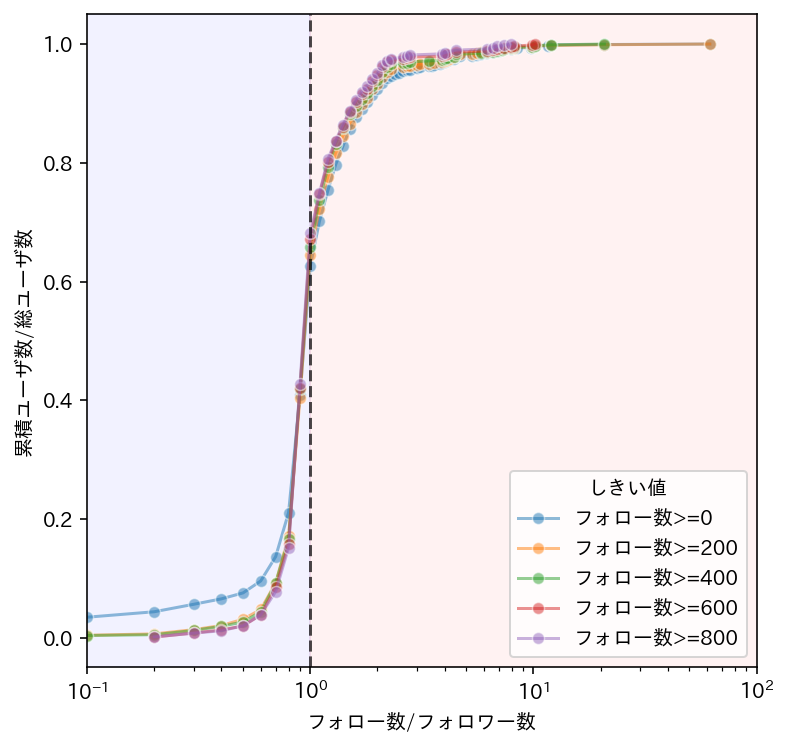

In [173]:
from matplotlib import pyplot as plt
import seaborn as sns
import japanize_matplotlib

%config InlineBackend.figure_formats = {'png', 'retina'}
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)

for threshhold in legends:
    #sns.scatterplot(x='index', y='prob_cum_sum_user', data = target_df, hue='threshhold', ax=ax, alpha=0.7)
    sns.lineplot(x='following/followers', y='prob_cum_sum_user', data = target_df[target_df['threshhold']==threshhold], ax=ax, alpha=0.5, marker='o')
ax.set(ylabel='累積ユーザ数/総ユーザ数', xlabel='フォロー数/フォロワー数', xscale='log', xlim=[0.1,100])
ax.axvline(1, color='k', ls="--", alpha=0.7)
ax.axvspan(0.0001, 1, color="blue", alpha=0.05, label=False)
ax.axvspan(1, 100, color="red", alpha=0.05, label=False)
plt.legend(labels=legends, title = "しきい値", loc ='lower right')

[Text(0, 0.5, 'フォロー数'), Text(0.5, 0, 'フォロワー数'), (0.0, 1000.0), (0.0, 1000.0)]

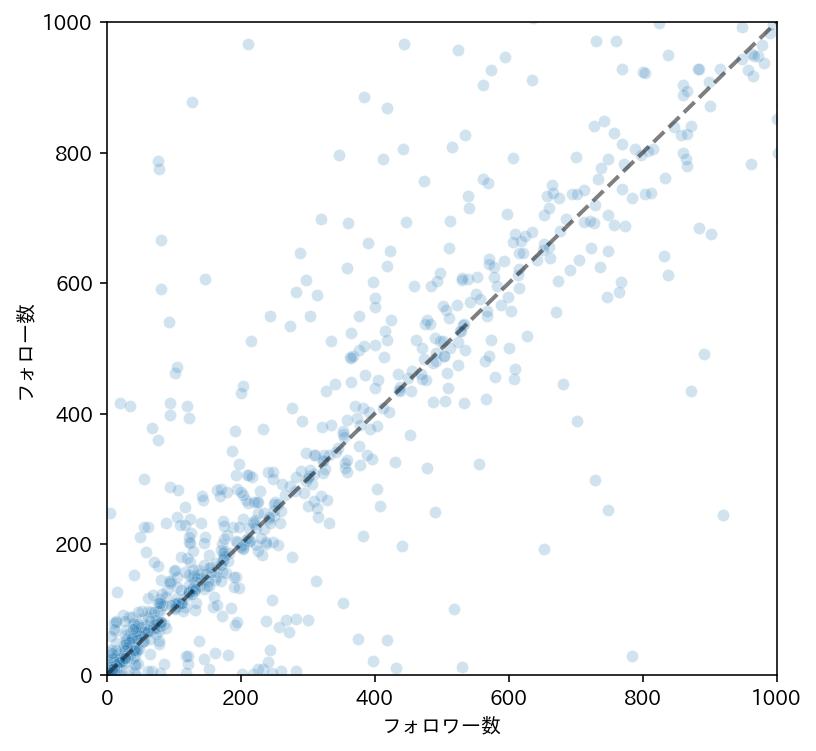

In [186]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(x='followers', y='following', data=df, alpha=0.2, ax=ax)
ax.axline((0, 0), (2,2), linewidth=2, color='k', ls='--', alpha=0.5)
ax.set(ylabel='フォロー数', xlabel='フォロワー数', xlim=[0,1000], ylim=[0,1000])
